In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import sys, time, os, warnings, string, pickle
from os import listdir
from pickle import load
from collections import Counter
from pickle import dump
import re

import keras
import tensorflow as tf
from keras.utils import to_categorical, plot_model
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.layers import Input, Dense, BatchNormalization, LSTM, Embedding, Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import VGG16, preprocess_input

import tensorflow as tf

from tqdm import tqdm

In [ ]:
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))

python 3.6.9 (default, Jul 17 2020, 12:50:27) 
[GCC 8.4.0]
keras version 2.4.3
tensorflow version 2.3.0


## Loading Data

In [ ]:
def load_doc(filename):
  file = open(filename, 'r')
  text = file.read()
  file.close()
  return text

In [ ]:
image_dir = '/content/drive/My Drive/Colab Notebooks/Image Captioning/Flickr8k_Dataset'
images = listdir(image_dir)
print("Total no.of images: {}". format(len(images)))

Total no.of images: 16182


In [ ]:
file = open('/content/drive/My Drive/Colab Notebooks/Image Captioning/Flickr8k_Text/Flickr8k.token.txt')
text = file.read()
file.close()
print(text[:411])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .



### Making a Dataframe out of raw texts

In [ ]:
def load_desc(doc):
  mapping = []
  for line in doc.split('\n'):
    # split line on white space
    tokens = line.split('\t')
    #print(tokens)
    if len(tokens) < 2:
      continue
    # segregating image id from the description
    #image_id, image_desc = tokens[0], tokens[1:]
    # cleaning image id by removing the filename
    image_id = tokens[0].split('#')
    # converting desc token back to strings
    mapping.append(image_id + [tokens[1].lower()])
  return mapping

descriptions = load_desc(text)

In [ ]:
df_txt = pd.DataFrame(descriptions, columns = ['Filename', 'Index', 'Captions'])

In [ ]:
df_txt.head(10)

,Filename,Index,Captions
0,1000268201_693b08cb0e.jpg,0,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,1,a girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,2,a little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,3,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,4,a little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,0,a black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,1,a black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,2,a black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,3,two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,4,two dogs on pavement moving toward each other .


In [ ]:
# If any filename dosn't have .jpg extension at last then mark it as Invalid filename
def invalid_filename_check(df_txt):
  for filenames in df_txt["Filename"]:
    found = re.search("(.(jpg)$)", filenames)
    if (found):
        pass
    else:
        print("Error file: {}".format(filenames))

invalid_filename_check(df_txt)

Error file: 2258277193_586949ec62.jpg.1
Error file: 2258277193_586949ec62.jpg.1
Error file: 2258277193_586949ec62.jpg.1
Error file: 2258277193_586949ec62.jpg.1
Error file: 2258277193_586949ec62.jpg.1


In [ ]:
df_txt[df_txt['Filename'] == "2258277193_586949ec62.jpg.1"]

,Filename,Index,Captions
6730,2258277193_586949ec62.jpg.1,0,people waiting for the subway
6731,2258277193_586949ec62.jpg.1,1,some people looking out windows in a large bui...
6732,2258277193_586949ec62.jpg.1,2,three people are waiting on a train platform .
6733,2258277193_586949ec62.jpg.1,3,three people standing at a station .
6734,2258277193_586949ec62.jpg.1,4,two woman and one man standing near train trac...


In [ ]:
df_txt = df_txt[df_txt['Filename'] != '2258277193_586949ec62.jpg.1']
df_txt = df_txt[df_txt['Filename'] != '1084104085_3b06223afe.jpg']
df_txt.shape

(40450, 3)

### Some of the pictures together with the captions

In [ ]:
filenames = np.unique(df_txt.Filename)

<function matplotlib.pyplot.show>

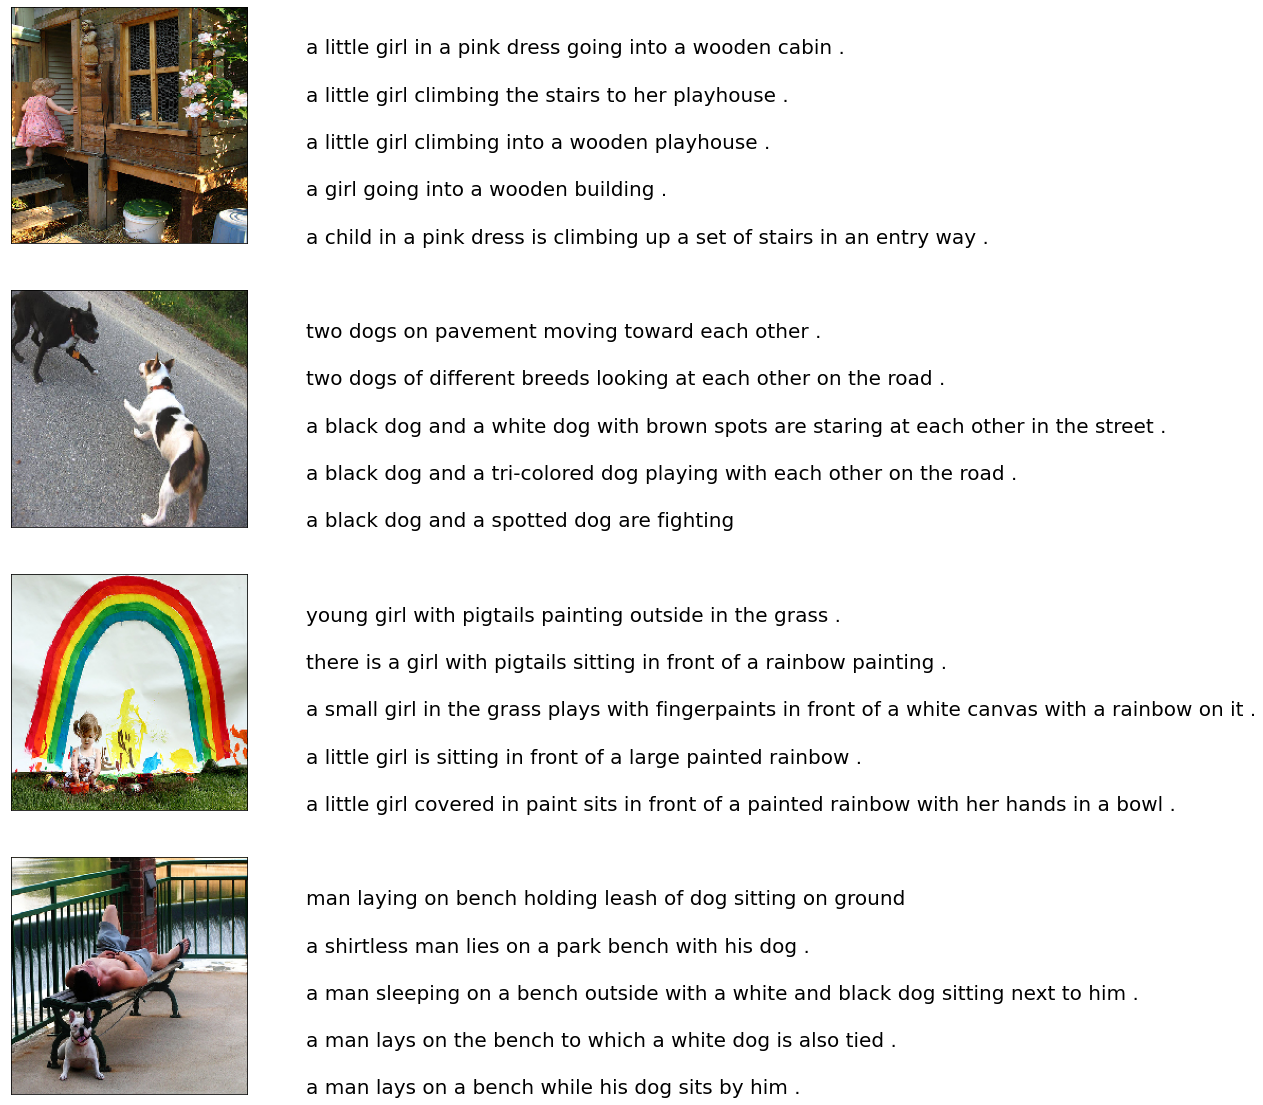

In [ ]:
npic = 4
npix = 224
target_size = (npix, npix, 3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in filenames[:npic]:
  filename = image_dir + '/' + jpgfnm
  captions = list(df_txt["Captions"].loc[df_txt["Filename"]==jpgfnm].values)
  img_load = load_img(filename, target_size=target_size)

  ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
  ax.imshow(img_load)
  count += 1

  ax = fig.add_subplot(npic, 2, count)
  plt.axis('off')
  ax.plot()
  ax.set_xlim(0,1)
  ax.set_ylim(0, len(captions))
  for i, caption in enumerate(captions):
    ax.text(0, i, caption, fontsize=20)
  count += 1
plt.show

## Data Preparation

### Summarizing the size of the vocabulary

In [ ]:
import collections
def df_vocab(df_txt):
  vocab = []
  for txt in df_txt.Captions.values:
    vocab.extend(txt.split())
  print('Size of vocabulary: %d' % len(set(vocab)))
  return vocab

vocabulary = df_vocab(df_txt)

Size of vocabulary: 8918


### Distribution of words

In [ ]:
def word_count(df_txt, vocab):
  ct = Counter(vocab)
  x = []
  y = []
  for i in ct.keys():
    x.append(i)
  for j in ct.values():
    y.append(j)
  dfword = pd.DataFrame({"word":x,"count":y})
  dfword = dfword.sort_values("count",ascending=False)
  dfword = dfword.reset_index()[["word","count"]]
  return(dfword)

dfword = word_count(df_txt, vocabulary)
dfword.head(7)

,word,count
0,a,62979
1,.,36572
2,in,18971
3,the,18416
4,on,10743
5,is,9341
6,and,8849


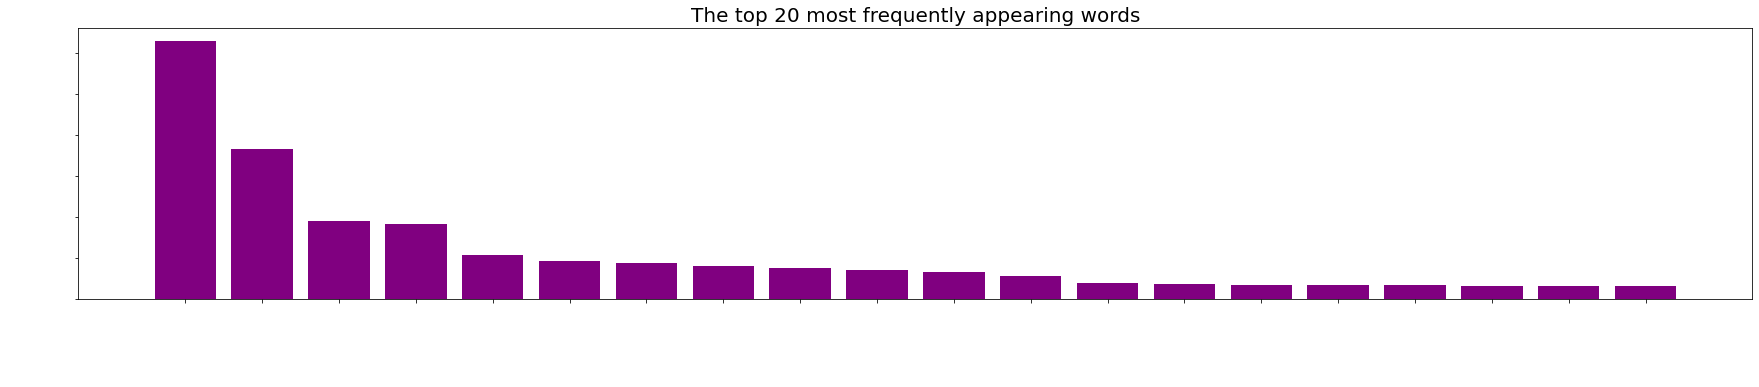

In [ ]:
# Visualizing the most and least frequently appearing words
top = 20

def plthist(dfsub, title):
  plt.figure(figsize=(30,5))
  plt.bar(dfsub.index, dfsub["count"], color = 'purple')
  plt.yticks(fontsize=20, color = 'white')
  plt.xticks(dfsub.index, dfsub["word"], rotation=90, fontsize=20,color='white')
  plt.title(title, fontsize=20)
  plt.show()

plthist(dfword.iloc[:top,:],
        title="The top 20 most frequently appearing words")

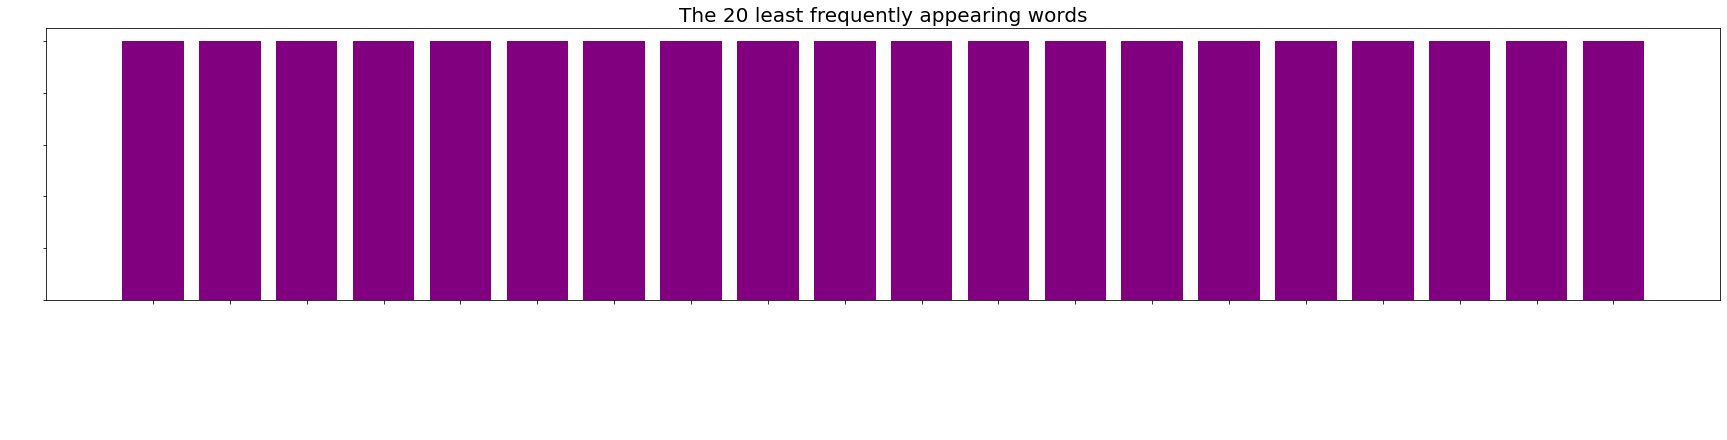

In [ ]:
plthist(dfword.iloc[-top:,:],
        title="The 20 least frequently appearing words")

### Cleaning the captions

In [ ]:
def remove_punctuation(text_original):
  # remove punctuation from each token
  text_no_punctuation = text_original.translate(string.punctuation)
  return (text_no_punctuation)

def remove_single_character(text):
  text_len_more_than1 = ""
  # removing single letter tokens
  for word in text.split():
    if len(word) > 1:
      text_len_more_than1 += " " + word
  return (text_len_more_than1)

def remove_numeric(text,printTF=False):
  text_no_numeric = ""
  # remove token with numbers in them
  for word in text.split():
    isalpha = word.isalpha()
    if printTF:
      print("    {:10} : {:}".format(word,isalpha))
    if isalpha:
      text_no_numeric += " " + word
  return (text_no_numeric)

def clean_desc(text_original):
  text = remove_punctuation(text_original)
  text = remove_single_character(text)
  text = remove_numeric(text)
  return (text)

In [ ]:
for i, caption in enumerate(df_txt.Captions.values):
  newcaption = clean_desc(caption)
  df_txt["Captions"].iloc[i] = newcaption

In [ ]:
df_txt.head(10)

,Filename,Index,Captions
0,1000268201_693b08cb0e.jpg,0,child in pink dress is climbing up set of sta...
1,1000268201_693b08cb0e.jpg,1,girl going into wooden building
2,1000268201_693b08cb0e.jpg,2,little girl climbing into wooden playhouse
3,1000268201_693b08cb0e.jpg,3,little girl climbing the stairs to her playhouse
4,1000268201_693b08cb0e.jpg,4,little girl in pink dress going into wooden c...
5,1001773457_577c3a7d70.jpg,0,black dog and spotted dog are fighting
6,1001773457_577c3a7d70.jpg,1,black dog and dog playing with each other on ...
7,1001773457_577c3a7d70.jpg,2,black dog and white dog with brown spots are ...
8,1001773457_577c3a7d70.jpg,3,two dogs of different breeds looking at each ...
9,1001773457_577c3a7d70.jpg,4,two dogs on pavement moving toward each other


In [ ]:
vocabulary = df_vocab(df_txt)

Size of vocabulary: 8357


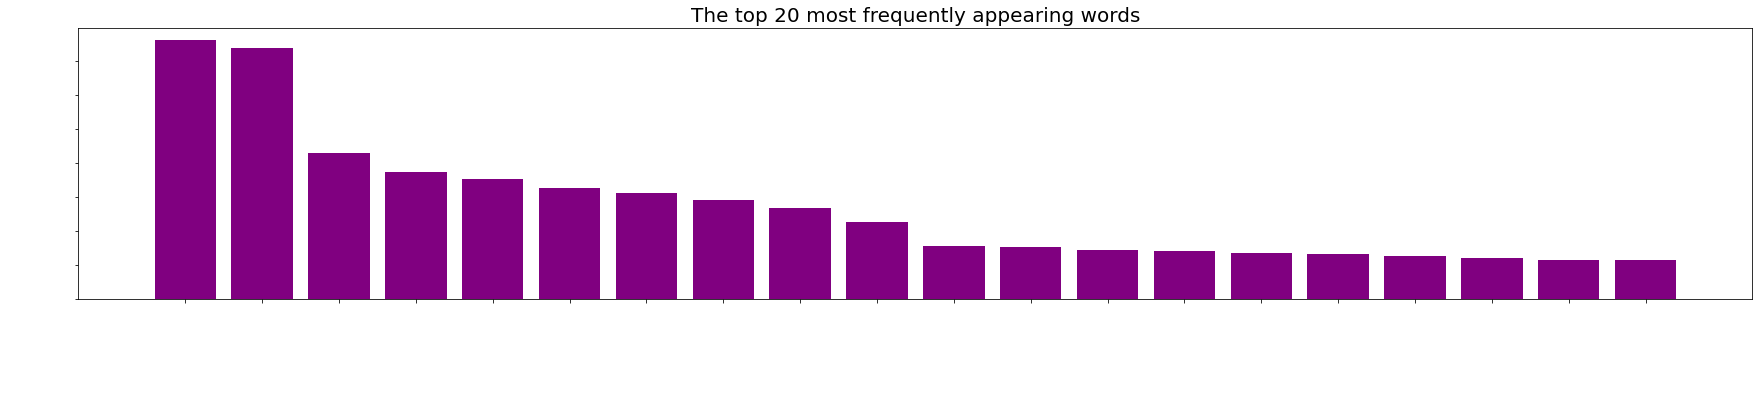

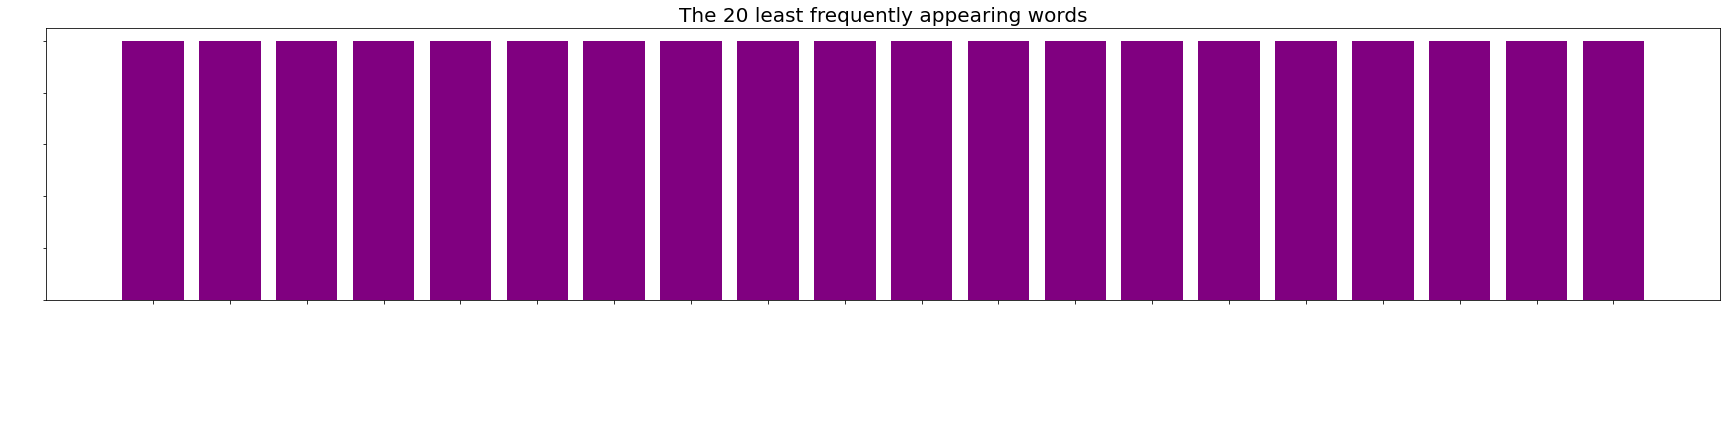

In [ ]:
dfword = word_count(df_txt, vocabulary)
plthist(dfword.iloc[:top,:],
        title="The top 20 most frequently appearing words")
plthist(dfword.iloc[-top:,:],
        title="The 20 least frequently appearing words")

### Add start and end sequence tokens

In [ ]:
def add_seq_token(captions):
  caps = []
  for txt in captions:
    txt = 'startseq ' + txt + ' endseq'
    caps.append(txt)
  return (caps)

In [ ]:
df_txt_copy = df_txt.copy()
df_txt['Captions'] = add_seq_token(df_txt['Captions'])
df_txt.head()

,Filename,Index,Captions
0,1000268201_693b08cb0e.jpg,0,startseq child in pink dress is climbing up s...
1,1000268201_693b08cb0e.jpg,1,startseq girl going into wooden building endseq
2,1000268201_693b08cb0e.jpg,2,startseq little girl climbing into wooden pla...
3,1000268201_693b08cb0e.jpg,3,startseq little girl climbing the stairs to h...
4,1000268201_693b08cb0e.jpg,4,startseq little girl in pink dress going into...


In [ ]:
total_captions = df_txt['Captions'].tolist()
total_captions[:10]

['startseq  child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq  girl going into wooden building endseq',
 'startseq  little girl climbing into wooden playhouse endseq',
 'startseq  little girl climbing the stairs to her playhouse endseq',
 'startseq  little girl in pink dress going into wooden cabin endseq',
 'startseq  black dog and spotted dog are fighting endseq',
 'startseq  black dog and dog playing with each other on the road endseq',
 'startseq  black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq  two dogs of different breeds looking at each other on the road endseq',
 'startseq  two dogs on pavement moving toward each other endseq']

In [ ]:
print(len(total_captions))

40450


### Setting a path

In [ ]:
def preprocess_images(df_txt_copy):
  all_img_name_vector = []
  for filename in df_txt_copy['Filename']:
    image_path = image_dir + "/" + filename
    all_img_name_vector.append(image_path)
  return all_img_name_vector

In [ ]:
all_image_name_vector = preprocess_images(df_txt_copy)

In [ ]:
all_image_name_vector[:10]

['/content/drive/My Drive/Colab Notebooks/Image Captioning/Flickr8k_Dataset/1000268201_693b08cb0e.jpg',
 '/content/drive/My Drive/Colab Notebooks/Image Captioning/Flickr8k_Dataset/1000268201_693b08cb0e.jpg',
 '/content/drive/My Drive/Colab Notebooks/Image Captioning/Flickr8k_Dataset/1000268201_693b08cb0e.jpg',
 '/content/drive/My Drive/Colab Notebooks/Image Captioning/Flickr8k_Dataset/1000268201_693b08cb0e.jpg',
 '/content/drive/My Drive/Colab Notebooks/Image Captioning/Flickr8k_Dataset/1000268201_693b08cb0e.jpg',
 '/content/drive/My Drive/Colab Notebooks/Image Captioning/Flickr8k_Dataset/1001773457_577c3a7d70.jpg',
 '/content/drive/My Drive/Colab Notebooks/Image Captioning/Flickr8k_Dataset/1001773457_577c3a7d70.jpg',
 '/content/drive/My Drive/Colab Notebooks/Image Captioning/Flickr8k_Dataset/1001773457_577c3a7d70.jpg',
 '/content/drive/My Drive/Colab Notebooks/Image Captioning/Flickr8k_Dataset/1001773457_577c3a7d70.jpg',
 '/content/drive/My Drive/Colab Notebooks/Image Captioning/Flick

In [ ]:
print(len(all_image_name_vector))

40450


### Selecting 40,000 images and captions

In [ ]:
def data_limiter(num,total_captions,all_image_name_vector):
  # Shuffle captions and image_names together
  train_captions, img_name_vector = shuffle(total_captions, all_image_name_vector, random_state=1)
  train_captions = train_captions[:num]
  img_name_vector = img_name_vector[:num]
  return train_captions,img_name_vector

In [ ]:
train_captions,img_name_vector = data_limiter(40000,total_captions,all_image_name_vector)

In [ ]:
print("Total Captions = {0} , Total images = {1}".format(len(train_captions),len(img_name_vector)))

Total Captions = 40000 , Total images = 40000


In [ ]:
# save to file
dump(train_captions, open('/content/drive/My Drive/Colab Notebooks/Image Captioning/with attention/captions.pkl', 'wb'))
dump(img_name_vector, open('/content/drive/My Drive/Colab Notebooks/Image Captioning/with attention/img_names.pkl', 'wb'))

In [ ]:
train_captions = load(open('/content/drive/My Drive/Colab Notebooks/Image Captioning/with attention/captions.pkl', 'rb'))
img_name_vector = load(open('/content/drive/My Drive/Colab Notebooks/Image Captioning/with attention/img_names.pkl', 'rb'))

### Visualizing images

Shape of the image:(333, 500, 3)


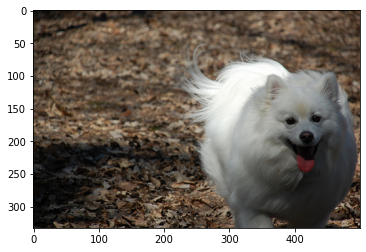

In [ ]:
# To know the shape of images
def image_and_shapes(image):
  img= plt.imread(image)
  plt.imshow(img)
  print("Shape of the image:{}".format(img.shape))

image_and_shapes("/content/drive/My Drive/Colab Notebooks/Image Captioning/Flickr8k_Dataset/3439243433_d5f3508612.jpg")

Shape of the image:(375, 500, 3)


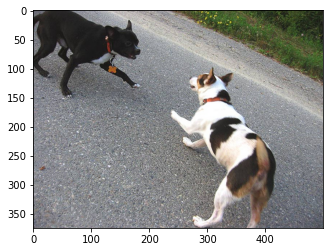

In [ ]:
image_and_shapes("/content/drive/My Drive/Colab Notebooks/Image Captioning/Flickr8k_Dataset/1001773457_577c3a7d70.jpg")

Shape of the image:(500, 333, 3)


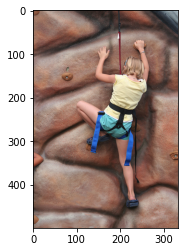

In [ ]:
image_and_shapes("/content/drive/My Drive/Colab Notebooks/Image Captioning/Flickr8k_Dataset/1084104085_3b06223afe.jpg")

### Image Augmentation

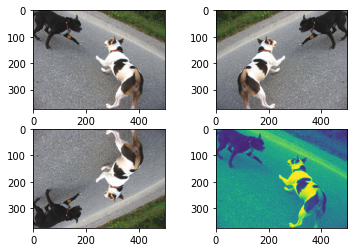

In [ ]:
import imageio
def image_flipper(image):
  original_img = imageio.imread(image)
  
  plt.figure(1)

#Original Image

  plt.subplot(221)
  plt.imshow(original_img)

#Left-Right flip Image

  flipped_img_tensor = tf.image.flip_left_right(original_img)
  flipped_img= flipped_img_tensor.numpy()
  plt.subplot(222)
  plt.imshow(flipped_img)

#Up-Down flip Image

  upside_down_flip_tensor = tf.image.flip_up_down(original_img)
  upside_down_flip= upside_down_flip_tensor.numpy()
  plt.subplot(223)
  plt.imshow(upside_down_flip)

#Gray scale Image

  gray_tensor = tf.image.rgb_to_grayscale(original_img)
  grayimg= gray_tensor.numpy()
  plt.subplot(224)
  plt.imshow(tf.squeeze(grayimg))

  #plt.imsave('doggo.jpg',flipped_img)

image_flipper("/content/drive/My Drive/Colab Notebooks/Image Captioning/Flickr8k_Dataset/1001773457_577c3a7d70.jpg")


### Image reshaping

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape after resize : (224, 224, 3)


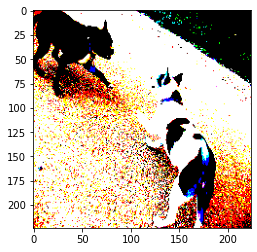

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = preprocess_input(img)
    return img, image_path

img1,img1_path = load_image("/content/drive/My Drive/Colab Notebooks/Image Captioning/Flickr8k_Dataset/1001773457_577c3a7d70.jpg")
print("Shape after resize :", img1.shape)
plt.imshow(img1)

## Model Building

The VGG16 takes the input size (224,224,3).

In [ ]:
image_model =  tf.keras.applications.VGG16(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(inputs = new_input, outputs = image_model.layers[-1].output)
image_features_extract_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)  

### Feature Extraction from VGG16

In [ ]:
# All unique images
encode_train = sorted(set(img_name_vector))
print(encode_train[:5])

['/content/drive/My Drive/Colab Notebooks/Image Captioning/Flickr8k_Dataset/1000268201_693b08cb0e.jpg', '/content/drive/My Drive/Colab Notebooks/Image Captioning/Flickr8k_Dataset/1001773457_577c3a7d70.jpg', '/content/drive/My Drive/Colab Notebooks/Image Captioning/Flickr8k_Dataset/1002674143_1b742ab4b8.jpg', '/content/drive/My Drive/Colab Notebooks/Image Captioning/Flickr8k_Dataset/1003163366_44323f5815.jpg', '/content/drive/My Drive/Colab Notebooks/Image Captioning/Flickr8k_Dataset/1007129816_e794419615.jpg']


In [ ]:
# getting the slices of an array in the form of objects
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)

In [ ]:
# Map each image name to the function to load the image 
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [ ]:
image_dataset

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.string)>

### Creating npy files

In [ ]:
# for img, path in tqdm(image_dataset):
#   batch_features = image_features_extract_model(img)
#   batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
#   for bf, p in zip(batch_features, path):
#     path_of_feature = p.numpy().decode("utf-8")
#     np.save(path_of_feature, bf.numpy())

In [ ]:
np_img =np.load('/content/drive/My Drive/Colab Notebooks/Image Captioning/Flickr8k_Dataset/3338291921_fe7ae0c8f8.jpg.npy')
print(np_img)
print("Shape : {}".format(np_img.shape))

[[0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        3.9950376 0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]]
Shape : (49, 512)


### Tokenizing the captions and creating vocabulary


In [ ]:
def tokenize_caption(top_k, train_captions):
  tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
  tokenizer.fit_on_texts(train_captions)
  train_seqs = tokenizer.texts_to_sequences(train_captions)

  # Map <pad> to '0'
  tokenizer.word_index['<pad>'] = 0
  tokenizer.index_word[0] = '<pad>'

  # Create the tokenize vectors
  train_seqs = tokenizer.texts_to_sequences(train_captions)
  return train_seqs, tokenizer

train_seqs, tokenizer = tokenize_caption(5000, train_captions)

In [ ]:
train_captions[:5]

['startseq  woman outside throws horseshoe endseq',
 'startseq  boy wearing black wetsuit stands on crowded beach endseq',
 'startseq  woman on the street window shops in front of the store louis vuitton endseq',
 'startseq  small black and white dog carrying red bucket in his mouth endseq',
 'startseq  child in red shirt plays with fireworks endseq']

In [ ]:
# Sentences converted to sequences
train_seqs[:5]

[[2, 18, 81, 563, 3355, 3],
 [2, 16, 21, 15, 481, 79, 6, 517, 66, 3],
 [2, 18, 6, 5, 72, 335, 1823, 4, 47, 12, 5, 387, 3356, 3357, 3],
 [2, 51, 15, 8, 14, 9, 135, 25, 601, 4, 29, 68, 3],
 [2, 42, 4, 25, 37, 114, 10, 1471, 3]]

In [ ]:
tokenizer.oov_token # used to replace out of vocabulary words 

'<unk>'

### Maxlength and minlength of any captions

In [ ]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

# Find the minimum length of any caption in our dataset
def calc_min_length(tensor):
    return min(len(t) for t in tensor)
# Calculates the min_length, which is used to store the attention weights
min_length = calc_min_length(train_seqs)

In [ ]:
print("Max length of a caption: " + str(max_length))
print("Min length of a caption: " + str(min_length))

Max length of a caption: 33
Min length of a caption: 2


### Padding each vector to max_length

In [ ]:
def pad_seq(train_seqs,max_length):
  cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post', maxlen=max_length)
  return cap_vector

In [ ]:
padded_caps = pad_seq(train_seqs,max_length)
print(padded_caps.shape)

(40000, 33)


In [ ]:
padded_caps

array([[   2,   18,   81, ...,    0,    0,    0],
       [   2,   16,   21, ...,    0,    0,    0],
       [   2,   18,    6, ...,    0,    0,    0],
       ...,
       [   2,   19,   49, ...,    0,    0,    0],
       [   2,   11,  997, ...,    0,    0,    0],
       [   2, 2770, 2048, ...,    0,    0,    0]], dtype=int32)

### Train-Test Split

In [ ]:
img_name_train, img_name_test, caption_train, caption_test = train_test_split(img_name_vector, padded_caps, test_size = 0.2, random_state=0)

In [ ]:
print("Training Data : X = {0},Y = {1}".format(len(img_name_train), len(caption_train)))
print("Test Data : X = {0},Y = {1}".format(len(img_name_test), len(caption_test)))

Training Data : X = 32000,Y = 32000
Test Data : X = 8000,Y = 8000


### Loading the .npy files

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
from keras.models import load_model
def load_npy(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy', encoding='latin1', allow_pickle=True)
  return img_tensor, cap

In [ ]:
def create_dataset(img_name_train,caption_train):
  dataset = tf.data.Dataset.from_tensor_slices((img_name_train, caption_train))
  # Use map to load the numpy files in parallel
  dataset = dataset.map(lambda item1, item2: tf.numpy_function(load_npy, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)
  # Shuffle and batch
  dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [ ]:
# Creating train and test dataset
train_dataset = create_dataset(img_name_train,caption_train)

In [ ]:
test_dataset = create_dataset(img_name_test,caption_test)

In [ ]:
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1 #8329
num_steps = len(img_name_train) // BATCH_SIZE  #500
EPOCHS = 20
features_shape = 512
attention_features_shape = 49 

### CNN Encoder

In [ ]:
class VGG16_Encoder(tf.keras.Model):
    # This encoder passes the features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(VGG16_Encoder, self).__init__()
        # shape after fc == (batch_size, 49, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)
        self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

    def call(self, x):
        #x= self.dropout(x)
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x 

In [ ]:
def rnn_type(units):
  # If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
  # the code automatically does that.
    if tf.test.is_gpu_available():
        return tf.compat.v1.keras.layers.CuDNNLSTM(units, 
                                        return_sequences=True, 
                                        return_state=True, 
                                        recurrent_initializer='glorot_uniform')
    else:
        return tf.keras.layers.GRU(units, 
                                   return_sequences=True, 
                                   return_state=True, 
                                   recurrent_activation='sigmoid', 
                                   recurrent_initializer='glorot_uniform')

### RNN Decoder
- With local attention

In [ ]:
class Rnn_Local_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(Rnn_Local_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    
    self.fc1 = tf.keras.layers.Dense(self.units)

    self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
    self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

    self.fc2 = tf.keras.layers.Dense(vocab_size)

    # Implementing Attention Mechanism 
    self.Uattn = tf.keras.layers.Dense(units)
    self.Wattn = tf.keras.layers.Dense(units)
    self.Vattn = tf.keras.layers.Dense(1)
    


  def call(self, x, features, hidden):
    
    # features shape ==> (64,49,256) ==> Output from ENCODER
    
    # hidden shape == (batch_size, hidden_size) ==>(64,512)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size) ==> (64,1,512)
    
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    
    # score shape == (64, 49, 1)
    # Attention Function
    '''e(ij) = f(s(t-1),h(j))'''
    ''' e(ij) = Vattn(T)*tanh(Uattn * h(j) + Wattn * s(t))'''
    score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))
    # self.Uattn(features) : (64,49,512)
    # self.Wattn(hidden_with_time_axis) : (64,1,512)
    # tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)) : (64,49,512)
    # self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis))) : (64,49,1) ==> score
    # you get 1 at the last axis because you are applying score to self.Vattn
    
    
    # Then find Probability using Softmax
    '''attention_weights(alpha(ij)) = softmax(e(ij))'''
    attention_weights = tf.nn.softmax(score, axis=1)
    # attention_weights shape == (64, 49, 1)

    
    # Give weights to the different pixels in the image
    ''' C(t) = Summation(j=1 to T) (attention_weights * VGG-16 features) ''' 
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)
    # Context Vector(64,256) = AttentionWeights(64,49,1) * features(64,49,256)
    # context_vector shape after sum == (64, 256)
    
    
    # x shape after passing through embedding == (64, 1, 256)
    x = self.embedding(x)
    
    # x shape after concatenation == (64, 1,  512)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # Adding Dropout and BatchNorm Layers
    x= self.dropout(x)
    x= self.batchnormalization(x)
    # output shape == (64 * 512)
    x = self.fc2(x)
    # shape : (64 * 8329(vocab))
    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

- with global attention

In [ ]:
class Rnn_Global_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size,scoring_type):
        super(Rnn_Global_Decoder, self).__init__()
        

        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        
        
        
        self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        
        self.wc = tf.keras.layers.Dense(units, activation='tanh')
        self.ws = tf.keras.layers.Dense(vocab_size)

        #For Attention
        self.wa = tf.keras.layers.Dense(units)
        self.wb = tf.keras.layers.Dense(units)
        
        #For Score 3 i.e. Concat score
        self.Vattn = tf.keras.layers.Dense(1)
        self.wd = tf.keras.layers.Dense(units, activation='tanh')

        self.scoring_type = scoring_type

        
    def call(self, sequence, features,hidden):
        
        # features : (64,49,256)
        # hidden : (64,512)
        
        embed = self.embedding(sequence)
        # embed ==> (64,1,256) ==> decoder_input after embedding (embedding dim=256)
       
        output, state = self.gru(embed)       
        #output :(64,1,512)

        score=0
        
        #Dot Score as per paper(Dot score : h_t (dot) h_s') (NB:just need to tweak gru units to 256)
        '''----------------------------------------------------------'''
        if(self.scoring_type=='dot'):
          xt=output #(64,1,512)
          xs=features #(256,49,64)  
          score = tf.matmul(xt, xs, transpose_b=True) 
               
          #score : (64,1,49)

        '''----------------------------------------------------------'''
        '''----------------------------------------------------------'''



        # General Score as per Paper ( General score: h_t (dot) Wa (dot) h_s')
        '''----------------------------------------------------------'''
        if(self.scoring_type=='general'):
          score = tf.matmul(output, self.wa(features), transpose_b=True)
          # score :(64,1,49)
        '''----------------------------------------------------------'''
        '''----------------------------------------------------------'''




        # Concat score as per paper (score: VT*tanh(W[ht;hs']))    
        '''----------------------------------------------------------'''
        #https://www.tensorflow.org/api_docs/python/tf/tile
        if(self.scoring_type=='concat'):
          tiled_features = tf.tile(features, [1,1,2]) #(64,49,512)
          tiled_output = tf.tile(output, [1,49,1]) #(64,49,512)
          
          concating_ht_hs = tf.concat([tiled_features,tiled_output],2) ##(64,49,1024)
          
          tanh_activated = self.wd(concating_ht_hs)
          score =self.Vattn(tanh_activated)
          #score :(64,49,1), but we want (64,1,49)
          score= tf.squeeze(score, 2)
          #score :(64,49)
          score = tf.expand_dims(score, 1)
          
          #score :(64,1,49)
        '''----------------------------------------------------------'''
        '''----------------------------------------------------------'''



        # alignment vector a_t
        alignment = tf.nn.softmax(score, axis=2)
        # alignment :(64,1,49)

        # context vector c_t is the average sum of encoder output
        context = tf.matmul(alignment, features)
        # context : (64,1,256)
        
        # Combine the context vector and the LSTM output
        
        output = tf.concat([tf.squeeze(context, 1), tf.squeeze(output, 1)], 1)
        # output: concat[(64,1,256):(64,1,512)] = (64,768)

        output = self.wc(output)
        # output :(64,512)

        # Finally, it is converted back to vocabulary space: (batch_size, vocab_size)
        logits = self.ws(output)
        # logits/predictions: (64,8239) i.e. (batch_size,vocab_size))

        return logits, state, alignment

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
scoring_type = input('Enter the scoring method:  ')

Enter the scoring method:  general


In [ ]:
attention_choice = input("Choose the type of Attention Mechanism you want to apply: ")

Choose the type of Attention Mechanism you want to apply: local


In [ ]:
if (attention_choice=='local'):
    encoder = VGG16_Encoder(embedding_dim)
    decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)

else:
    encoder = VGG16_Encoder(embedding_dim)
    decoder = Rnn_Global_Decoder(embedding_dim, units, vocab_size,scoring_type)

In [ ]:
decoder

### Encoder features

In [ ]:
def Encoder_features(img_tensor, target):
  features = encoder(img_tensor)
  return features,target,img_tensor

for (batch, (img_tensor, target)) in enumerate(train_dataset):
  features,target,img_tensor= Encoder_features(img_tensor, target)

KeyboardInterrupt: ignored

In [ ]:
target.shape # (batch_size,max_length)

In [ ]:
img_tensor.shape #(batch_size,attention_feature_shape,feature_shape)

In [ ]:
 features.shape #(batch_size,attention_feature_shape,feature_shape)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

### Saving Checkpoint

In [ ]:
checkpoint_path_ckpt = "/content/drive/My Drive/Colab Notebooks/Image Captioning/checkpoint_finally19/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

- Start checkpointing from the checkpoint last saved

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

### Training Step:
- You extract the features stored in the respective .npy files and then pass those features through the encoder.
- The encoder output, hidden state(initialised to 0) and the decoder input(which is the _'startseq'_ token) is passed to the decoder.
- The decoder returns the predictions and the decoder hidden state.
- The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss. While training, we use the Teacher Forcing technique, to decide the next input of the decoder.
 - __Teacher Forcing__ is the technique where the target word is passed as the next input to the decoder. This technique helps to learn the correct sequence or correct statistical properties fro the sequence, quickly.  
  To learn more about teacher forcing: https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/
- The final step is to calculate the Gradient and apply it to the optimizer and backpropagate 

### Tensorboard Summary Writer

In [ ]:
# Clear previous logs
!rm -rf ./logs/ 

In [ ]:
# Define our metrics
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)

In [ ]:
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['startseq']] * BATCH_SIZE, 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)
          

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
test_loss_plot = []

@tf.function
def test_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['startseq']] * BATCH_SIZE, 1)

  features = encoder(img_tensor)

  for i in range(1, target.shape[1]):
      # passing the features through the decoder

      
      predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
      # predictions : (64,8329)
      loss += loss_function(target[:, i], predictions)
      
      predicted_id = tf.argmax(predictions[0])
      dec_input = tf.expand_dims([predicted_id]*BATCH_SIZE, 1)
 

  total_loss = (loss / int(target.shape[1]))

  return loss, total_loss

## Training

In [ ]:
for epoch in range(start_epoch, 20):
    start = time.time()

    #For Train
    #================================================================
    total_loss_train = 0
    for (batch, (img_tensor, target)) in enumerate(train_dataset):
      batch_loss, t_loss = train_step(img_tensor, target)
      total_loss_train += t_loss
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss_train / num_steps)

    # Tensorboard 
    with train_summary_writer.as_default():
      tf.summary.scalar('LossPlotTrain', (total_loss_train/ num_steps), step=epoch)
      tf.summary.scalar('Train_loss', train_loss.result(), step=epoch)

    #For Test
    #================================================================
    total_loss_test = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
      batch_loss, t_loss = test_step(img_tensor, target)
      total_loss_test += t_loss
    # storing the epoch end loss value to plot later
    test_loss_plot.append(total_loss_test / num_steps) 

    # Tensorboard 
    with test_summary_writer.as_default():
      tf.summary.scalar('LossPlotTest', (total_loss_test/ num_steps), step=epoch)

    
    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} TrainLoss {:.6f} TestLoss {:.6f}'.format(epoch + 1,(total_loss_train/num_steps),(total_loss_test/num_steps)))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/gradient_tape

In [ ]:
ckpt_manager.checkpoints

In [ ]:
ckpt.restore('./checkpoint_finally19/train/ckpt-4')

In [ ]:
for label in [loss_plot,test_loss_plot]:
    plt.plot(label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Evaluating